<a href="https://colab.research.google.com/github/serzaraisk/Statistics/blob/main/Statistics_cheat_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [2]:
! pip install bootstrap_stat

import numpy as np
import pandas as pd
import scipy as sc
import requests
import base64
from statsmodels.stats.weightstats import DescrStatsW 
from bootstrap_stat import bootstrap_stat as bp
from statsmodels.sandbox.stats.multicomp import multipletests 
%pylab inline

     |████████████████████████████████| 81kB 5.4MB/s 
     |████████████████████████████████| 71kB 7.6MB/s 


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Populating the interactive namespace from numpy and matplotlib


## UDF

In [13]:
def get_txt_from_github(url):
  req = requests.get(url)
  return req.text.decode()

def t_confidence_intervals(data, alpha=0.05, alternative='two-sided'):
    return DescrStatsW(data).tconfint_mean(alpha=alpha, alternative=alternative)

def t_confidence_intervals_only_scipy(data, aplha=0.05):
    mean = data.mean()
    std = data.std(ddof=1)
    n = len(data)
    alpha = 0.05
    CI = (mean - sc.stats.t.ppf(1 - alpha / 2.0, n-1) * std / np.sqrt(n),
          mean + sc.stats.t.ppf(1 - alpha / 2.0, n-1) * std / np.sqrt(n))
    return CI

def get_bootstrap_samples(x, n_resamples):
    np.random.seed(0)
    indices = np.random.randint(0, len(x), (n_resamples, len(x)))
    resamples = x[indices]
    return resamples

def percentile_interval(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

def bca_bootstrap_interval(df, func, bootstrap_num=5000):
    ed = bp.EmpiricalDistribution(df)
    return bp.bcanon_interval(ed, func, df, B=bootstrap_num)

def bca_bootstrap_interval_for_two_samples(df1, df2, func, bootstrap_num=5000):
    joint_dist = bp.MultiSampleEmpiricalDistribution((ilec_time, clec_time))
    return bp.bcanon_interval(joint_dist, func, (df1, df2), B=bootstrap_num)

def adjust_p_value_holms(p_values, alpha=0.5):
    """
    adjust array of p_values based on holms step down method
    p_values: array of p-values(Series)
    """
    _, expression['p_adjusted_holm'], _, _ = multipletests(p_values, alpha = 0.05, method = 'holm') 
    return expression['p_adjusted_holm']

def adjust_p_value_bonferroni(p_values, alpha=0.5):
    """
    adjust array of p_values based on bonferroni method
    p_values: array of p-values(Series)
    
    """
    _, expression['p_adjusted_holm'], _, _ = multipletests(p_values, alpha = 0.05, method = 'bonferroni') 
    return expression['p_adjusted_holm']

def adjust_p_value_fdr_bh(p_values, alpha=0.5):
    """
    adjust array of p_values based on fdr_bh step up method
    p_values: array of p-values(Series)
    """
    _, expression['p_adjusted_holm'], _, _ = multipletests(p_values, alpha = 0.05, method = 'fdr_bh') 
    return expression['p_adjusted_holm']

# Contents


*   List item

*   List item
*   List item


*   List item



## T confindence Intervals

*Use when you want to estimate population parameter, given that your parameter is distributed normally and you don't know population variance*

UDF:


1.   **t_confidence_intervals**
2.   **t_confidence_intervals_only_scipy** 


**Example**: For a sample of 915 biochemistry graduate students we now hom many papers they produced during the last 3 years of their PhD prodram. 

How do we estimate the average number of papers with uncertainty?

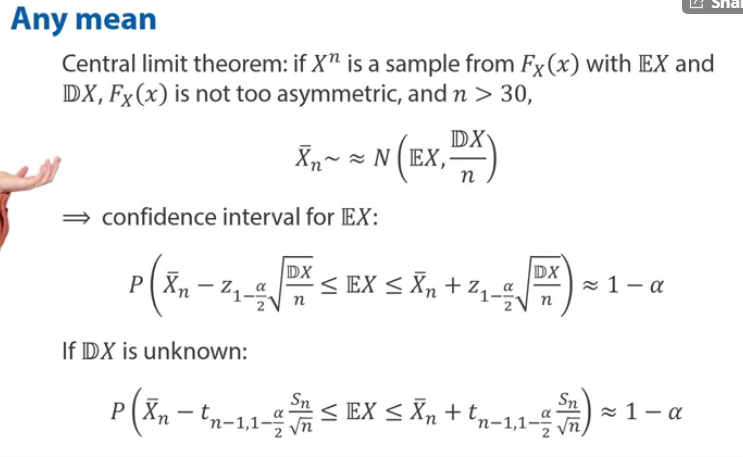

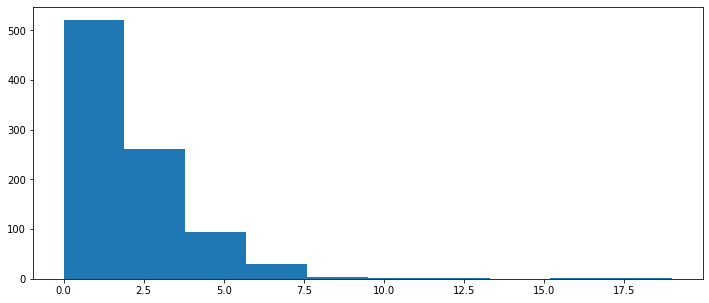

In [ ]:
from numpy import loadtxt
bio_papers = loadtxt('https://raw.githubusercontent.com/serzaraisk/Statistics/main/bioChemists.txt')
plt.hist(bio_papers);

### Estimating the mean
Simple point estimate of the mean:

In [ ]:
bio_papers.mean()

1.692896174863388

Asymptotic confidence interval:

In [ ]:
print("95% confidence interval:", t_confidence_intervals(bio_papers))

95% confidence interval: (1.5679321925466905, 1.8178601571800854)


Another way to calculate it:

In [ ]:
from statsmodels.stats.weightstats import _tconfint_generic
n = len(bio_papers)
print("95% confidence interval:", _tconfint_generic(bio_papers.mean(), 
                                                    bio_papers.std(ddof=1) / np.sqrt(n),
                                                    dof = n-1,
                                                    alpha=0.05,
                                                    alternative = 'two-sided'))

95% confidence interval: (1.5679321925466905, 1.8178601571800854)


Yet another way, without any external libraries:

In [ ]:
print("95% confidence interval:", t_confidence_intervals_only_scipy(bio_papers))

95% confidence interval: (1.5679321925466905, 1.8178601571800854)


## BootStrap methods

*Use when want to estimate some parameter of population, without any assumptions about distribution of population*

UDF:


1.   **Percentile bootstrap**
  1.   **get_bootstrap_samples**
  2.   **percentile_interval**
2.   **BCA_bootstrap**
  1.   **bca_bootstrap_interval**
  2.   **bca_bootstrap_interval_for_two_samples**

Verizon was an Incumbent Local Exchange Carrier (ILEC), responsible for maintaining land-line phone service in certain areas. Verizon also sold long-distance service, as did a number of competitors, termed Competitive Local Exchange Carriers (CLEC). When something went wrong, Verizon was responsible for repairs, and was supposed to make repairs as quickly for CLEC long-distance customers as for their own. The New York Public Utilities Commission (PUC) monitored fairness by comparing repair times for Verizon and different CLECs, for different classes of repairs and time periods.

The data is for one combination of CLEC, class of service, and period.

In [ ]:
verizon_data = pd.read_csv('https://raw.githubusercontent.com/serzaraisk/Statistics/main/Input_data/verizon.txt', sep='\t')
verizon_data.head()

,Time,Group
0,17.50,ILEC
1,2.40,ILEC
2,0.00,ILEC
3,0.65,ILEC
4,22.23,ILEC


In [ ]:
ilec_time = verizon_data[verizon_data.Group == 'ILEC'].Time.values
clec_time = verizon_data[verizon_data.Group == 'CLEC'].Time.values

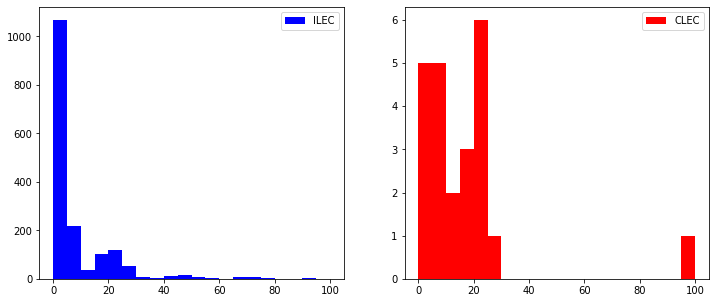

In [ ]:
pylab.figure(figsize(12, 5))
pylab.subplot(1,2,1)
pylab.hist(ilec_time, bins = 20, color = 'b', range = (0, 100), label = 'ILEC')
pylab.legend()

pylab.subplot(1,2,2)
pylab.hist(clec_time, bins = 20, color = 'r', range = (0, 100), label = 'CLEC')
pylab.legend();

### For a parameter of a single sample

In [ ]:
np.random.seed(0)

ilec_median_scores = list(map(np.median, get_bootstrap_samples(ilec_time, 5000)))
clec_median_scores = list(map(np.median, get_bootstrap_samples(clec_time, 5000)))

print("95% confidence interval for the ILEC median repair time:",  percentile_interval(ilec_median_scores, 0.05))
print("95% confidence interval for the CLEC median repair time:",  percentile_interval(clec_median_scores, 0.05))

95% confidence interval for the ILEC median repair time: [3.22  3.825]
95% confidence interval for the CLEC median repair time: [ 5.8  20.28]


### For a combination of parameters of two samples

In [ ]:
print("Estimated difference between repait times:", np.median(clec_time) - np.median(ilec_time))

Estimated difference between repait times: 10.74


In [ ]:
delta_median_scores = list(map(lambda x: x[1] - x[0], zip(ilec_median_scores, clec_median_scores)))
print("95% confidence interval for the difference between median repair times:",  
      percentile_interval(delta_median_scores, 0.05))

95% confidence interval for the difference between median repair times: [ 2.04 16.65]


### BCa bootstrap
An external library https://pypi.org/project/bootstrap-stat/ actually has more exciting bootstrap methods implemented, including BCa bootstrap! The library is rather new and fresh, but seems to be working fine! Here are the examples, you'd have to install the library if you want to run them. 

### For a parameter of a single sample

In [ ]:
print("95% confidence interval for the ILEC median repair time:", 
      bca_bootstrap_interval(ilec_time, np.median))
print("95% confidence interval for the CLEC median repair time:", 
      bca_bootstrap_interval(clec_time, np.median))

95% confidence interval for the ILEC median repair time: (3.28, 3.78)
95% confidence interval for the CLEC median repair time: (5.45, 19.88)


### For a combination of parameters of two samples

In [ ]:
joint_dist = bp.MultiSampleEmpiricalDistribution((ilec_time, clec_time))

def median_diff(two_sample_tuple):
    return np.median(two_sample_tuple[1]) - np.median(two_sample_tuple[0])

print("95% confidence interval for the difference between median repair times:", 
      bp.bcanon_interval(joint_dist, median_diff, (ilec_time, clec_time), B=5000))

print("95% confidence interval for the difference between median repair times:", 
      bca_bootstrap_interval_for_two_samples(ilec_time, clec_time, median_diff))

95% confidence interval for the difference between median repair times: (2.165, 16.4)
95% confidence interval for the difference between median repair times: (2.1899999999999995, 16.4)


## Familywise error rare and FRD
*Use when want to adjust p-values because of multiple hypothesis testing*

UDF:


1.   **adjust_p_value_holms**
2.   **adjust_p_value_bonferroni**
3.   **adjust_p_value_fdr_bh**


### Data: gene expression in white blood cells

We have data from the analysis of gene expression (level of activity of a gene) in white blood cells of children with severe therapy-resistant asthma, and healthy controls. Results provide insight into the molecular pathogenesis of  asthma. Data is collected with DNA microarrays: https://en.wikipedia.org/wiki/DNA_microarray

We would like to understand which genes have different average activity levels between healthy and diseased groups.

Data source: http://www.ncbi.nlm.nih.gov/sites/GDSbrowser?acc=GDS4896

In [3]:
expression = pd.read_csv('https://raw.githubusercontent.com/serzaraisk/Statistics/main/Input_data/expression.csv')

In [4]:
expression.head()

,ID_REF,IDENTIFIER,Healthy control,Healthy control.1,Healthy control.2,Healthy control.3,Healthy control.4,Healthy control.5,Healthy control.6,Healthy control.7,Healthy control.8,Healthy control.9,Healthy control.10,Healthy control.11,Healthy control.12,Healthy control.13,Healthy control.14,Healthy control.15,Healthy control.16,Healthy control.17,Severe asthma,Severe asthma.1,Severe asthma.2,Severe asthma.3,Severe asthma.4,Severe asthma.5,Severe asthma.6,Severe asthma.7,Severe asthma.8,Severe asthma.9,Severe asthma.10,Severe asthma.11,Severe asthma.12,Severe asthma.13,Severe asthma.14,Severe asthma.15,Severe asthma.16,Gene title
0,7933640,A1CF,4.24505,4.44464,4.36671,4.33497,4.45717,4.37972,4.40154,4.40521,4.47127,4.44672,4.40599,4.58952,4.29390,4.25316,4.52737,4.47072,4.30119,4.64295,4.36226,4.47737,4.36314,4.61266,4.42906,4.26465,4.44100,4.49613,4.59426,4.56012,4.60672,4.43026,4.55835,4.25656,4.52559,4.42976,4.37098,APOBEC1 complementation factor
1,7960947,A2M,4.79868,4.76833,4.66414,4.80272,4.85779,4.77622,4.92634,4.88576,5.00332,4.85915,4.46532,4.94817,4.79247,4.93248,4.86576,5.09963,4.76455,4.66645,5.27952,4.98797,5.06507,5.39660,4.80585,5.24319,5.21687,4.72301,5.01994,5.15406,5.13639,4.99052,4.88454,4.68904,4.85329,5.05764,5.48561,alpha-2-macroglobulin
2,7953775,A2ML1,4.79161,5.12633,4.93860,4.74597,4.91789,4.74453,5.23725,4.83903,4.91834,5.03532,4.76297,4.97604,4.86944,4.95659,5.05354,5.10546,5.11785,5.18866,4.62426,4.87333,4.91667,4.89983,4.86967,4.97828,5.18958,4.68325,5.22915,5.11131,5.33257,5.05544,4.96971,4.96505,4.76993,5.04489,4.70002,alpha-2-macroglobulin-like 1
3,8076497,A4GALT,5.79783,5.93942,5.82935,5.91139,5.60195,5.68317,6.01254,5.84921,6.10868,5.98903,5.45565,5.89648,5.62721,5.69318,5.89079,6.00670,5.83917,6.11561,5.65212,5.85599,6.02792,5.97044,5.89552,5.60008,5.84638,5.80428,6.16251,6.21829,6.06835,5.80154,6.06533,5.79955,5.94065,6.08192,5.86693,"alpha 1,4-galactosyltransferase"
4,8090955,A4GNT,3.79685,4.00154,3.83103,3.91021,3.81930,3.86203,3.97020,3.84166,3.96387,3.84821,3.85158,3.95916,3.90199,3.78189,3.86358,4.07321,3.80914,4.06682,3.78357,3.81996,3.64056,4.10096,4.13633,3.75070,4.03031,3.89729,4.17925,3.99698,4.09657,4.00232,3.70843,3.79290,4.31364,3.94925,3.62481,"alpha-1,4-N-acetylglucosaminyltransferase"


In [5]:
print("Number of genes in the study:", expression.shape[0])
healthy = [col for col in expression if col.startswith('Healthy')]
print("Number of healthy controls:", len(healthy))
asthma = [col for col in expression if col.startswith('Severe')]
print("Number of children with severe asthma:", len(asthma))

Number of genes in the study: 21465
Number of healthy controls: 18
Number of children with severe asthma: 17


In [6]:
expression['mean_healthy'] = expression[healthy].apply(np.mean, axis=1)
expression['mean_asthma'] = expression[asthma].apply(np.mean, axis=1)

For each gene, we are going to compare average expression levels between healthy children and children with severe asthma using t test:

In [7]:
def compare_groups(row):
    p = sc.stats.ttest_ind(row[healthy], row[asthma], equal_var = False).pvalue
    return p

expression['p'] = expression.apply(compare_groups, axis=1)

How many genes have significantly different average expression levels – without accounting for multiple hypotheses testing?

In [8]:
print('Number of significant differences, no correction for multiplicity:', sum(expression.p <= 0.05))

Number of significant differences, no correction for multiplicity: 2772


### Holm's method

Let's correct for multiple hypothesis testing using Holm's method to control FWER:

In [14]:
#_, expression['p_adjusted_holm'], _, _ = multipletests(expression.p, alpha = 0.05, method = 'holm') 
expression['p_adjusted_holm'] = adjust_p_value_holms(expression.p)
print('Number of significant differences with FWER <= 0.05:', sum(expression.p_adjusted_holm <= 0.05))
expression[expression.p_adjusted_holm <= 0.05][['IDENTIFIER', 'Gene title', 'mean_healthy', 'mean_asthma', 
                                                'p', 'p_adjusted_holm']]

Number of significant differences with FWER <= 0.05: 9


,IDENTIFIER,Gene title,mean_healthy,mean_asthma,p,p_adjusted_holm
431,AGPAT4-IT1,AGPAT4 intronic transcript 1 (non-protein coding),5.591794,5.906907,5.504217e-07,0.011812
2865,CD4,CD4 molecule,10.332761,9.994222,2.169653e-06,0.046554
7128,GPR21,G protein-coupled receptor 21,5.907257,6.853551,3.304167e-08,0.000709
7144,GPR52,G protein-coupled receptor 52,6.284526,7.202818,1.456452e-08,0.000313
10186,LPP,LIM domain containing preferred translocation ...,8.943248,9.276649,1.816116e-07,0.003897
12641,OCR1,ovarian cancer-related protein 1,7.043893,8.379184,9.935442e-08,0.002132
17245,SND1-IT1,SND1 intronic transcript 1 (non-protein coding),5.543953,6.252731,3.057326e-08,0.000656
18225,SYNE2,"spectrin repeat containing, nuclear envelope 2",8.603884,9.020421,1.323281e-06,0.028395
20763,ZEB2,zinc finger E-box binding homeobox 2,6.341786,7.358729,3.958029e-08,0.000849


Just for comparison – here's what we would get using Bonferroni's correction:

In [15]:
#_, expression['p_adjusted_bonf'], _, _ = multipletests(expression.p, alpha = 0.05, method = 'bonferroni') 
expression['p_adjusted_bonf'] = adjust_p_value_bonferroni(expression.p)
expression[expression.p_adjusted_bonf <= 0.05][['IDENTIFIER', 'Gene title', 'mean_healthy', 'mean_asthma', 
                                                'p', 'p_adjusted_bonf']]

,IDENTIFIER,Gene title,mean_healthy,mean_asthma,p,p_adjusted_bonf
431,AGPAT4-IT1,AGPAT4 intronic transcript 1 (non-protein coding),5.591794,5.906907,5.504217e-07,0.011815
2865,CD4,CD4 molecule,10.332761,9.994222,2.169653e-06,0.046572
7128,GPR21,G protein-coupled receptor 21,5.907257,6.853551,3.304167e-08,0.000709
7144,GPR52,G protein-coupled receptor 52,6.284526,7.202818,1.456452e-08,0.000313
10186,LPP,LIM domain containing preferred translocation ...,8.943248,9.276649,1.816116e-07,0.003898
12641,OCR1,ovarian cancer-related protein 1,7.043893,8.379184,9.935442e-08,0.002133
17245,SND1-IT1,SND1 intronic transcript 1 (non-protein coding),5.543953,6.252731,3.057326e-08,0.000656
18225,SYNE2,"spectrin repeat containing, nuclear envelope 2",8.603884,9.020421,1.323281e-06,0.028404
20763,ZEB2,zinc finger E-box binding homeobox 2,6.341786,7.358729,3.958029e-08,0.000850


It's the same 9 genes! We test so many hypotheses here that even the more powerful Holm's method is not able to reject more than Bonferroni's – controlling FWER is probably too strict.

### Benjamini-Hochberg's method
DNA microarrays are an exploratory tool – they are used to generate scientific hypotheses that later could be tested with more precise instruments. It might make sense to allow some type I errors to be able to have higher power.

Let's correct for multiple hypothesis testing using Benjamini-Hochberg's method to control FDR (as they usually do in microarray analysis):

In [16]:
#_, expression['p_adjusted_bh'], _, _ = multipletests(expression.p, alpha = 0.05, method = 'fdr_bh') 
expression['p_adjusted_bh'] = adjust_p_value_fdr_bh(expression.p)
print('Number of significant differences with FDR <= 0.05:', sum(expression.p_adjusted_bh <= 0.05))
with pd.option_context('display.max_rows', None):
    display(expression[expression.p_adjusted_bh <= 0.05][['IDENTIFIER', 'Gene title', 'mean_healthy', 
                                                          'mean_asthma', 'p', 'p_adjusted_bh']])

Number of significant differences with FDR <= 0.05: 168


,IDENTIFIER,Gene title,mean_healthy,mean_asthma,p,p_adjusted_bh
18,AAR2,AAR2 splicing factor homolog (S. cerevisiae),8.176038,7.995185,2.287793e-04,0.041617
135,ACBD3,acyl-CoA binding domain containing 3,9.503262,9.249920,6.883657e-06,0.008859
261,ADAM20,ADAM metallopeptidase domain 20,5.073112,5.413564,2.536561e-04,0.043725
315,ADCK2,aarF domain containing kinase 2,6.407213,6.209225,3.493704e-04,0.048863
431,AGPAT4-IT1,AGPAT4 intronic transcript 1 (non-protein coding),5.591794,5.906907,5.504217e-07,0.001688
582,ALKBH5,"AlkB family member 5, RNA demethylase",9.254869,9.035186,3.887820e-05,0.018019
662,ANGPTL1,angiopoietin-like 1,3.591168,3.921505,1.794481e-04,0.039998
738,ANKRD36,ankyrin repeat domain 36///ankyrin repeat doma...,8.897997,9.319184,3.227949e-05,0.016113
777,ANP32A-IT1,ANP32A intronic transcript 1 (non-protein coding),6.779091,7.190945,2.939759e-04,0.045086
854,APH1A,APH1A gamma secretase subunit,8.620867,8.342951,2.096931e-05,0.014390
